# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 1: Bag-of-Words based Natural Language Inference (30 pts)

In this assignment, you will train a Bag-of-Words encoder to tackle the Stanford Natural Language Inference (SNLI) task.

We have 5 coding questions and 3 written questions. Some coding functions are provided for your reference, but you are welcome to change and write your own functions. You should deliver your training and validation results in written questions.

In [19]:
# Import required packages
import os 
import numpy as np
import pickle as pkl
from collections import Counter

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [20]:
# save index 0 for unk and 1 for pad
global PAD_IDX, UNK_IDX
UNK_IDX = 0
PAD_IDX = 1

---
### 1 Dataset (6 pts)
#### Data Processing

In [21]:
# Read data
# tokenized data provided or you can tokenize data by your self
folder = os.getcwd() + '/data_after_process/'

hypo_data_tokens_train = pkl.load(open(folder+"hypo_data_tokens_train.p", "rb"))
prem_data_tokens_train = pkl.load(open(folder+"prem_data_tokens_train.p", "rb"))

hypo_data_tokens_val = pkl.load(open(folder+"hypo_data_tokens_val.p", "rb"))
prem_data_tokens_val = pkl.load(open(folder+"prem_data_tokens_val.p", "rb"))

label_index_train = pkl.load(open(folder+"label_index_train.p", "rb"))
label_index_val = pkl.load(open(folder+"label_index_val.p", "rb"))

**Coding 1: finish `build_vocab` function** (2 pts)


In [22]:
def build_vocab(hypo_tokens, prem_tokens, max_vocab_size=10000):
    # TODO:
    # build vocab
    # returns: 
    # - id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # - token2id: dictionary where keys represent tokens and corresponding values represent indices

    all_tokens = [hypo_token for tokens in hypo_tokens for hypo_token in tokens] # First appending hypo tokens
    all_prem_tokens = [prem_token for tokens in prem_tokens for prem_token in tokens]
    all_tokens.extend(all_prem_tokens)

    token_count = Counter(all_tokens)
    vocab,count = zip(*token_count.most_common(max_vocab_size))
    id2token = ["<UNK>","<PAD>"] + list(vocab)
    token2id = dict(zip(vocab, range(2, 2 + len(vocab)))) # Getting tokens and their indices
    token2id["<PAD>"] = PAD_IDX
    token2id["<UNK>"] = UNK_IDX

    return token2id,id2token

**Coding 2: finish `token2index` function** (2 pts)

In [23]:
def token2index(tokens_data,token2id):
    # TODO:
    # convert token to id in the dataset
    # returns:
    # - indices_data: return list of index_list (index list for each sentence)
    indices_data = []
    for tokens in tqdm(tokens_data):
      indices = [token2id.get(token, 1) for token in tokens]
      indices_data.append(indices)
    return indices_data


In [24]:
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size=10000)
hypo_data_indices_train = token2index(hypo_data_tokens_train,token2id)
prem_data_indices_train = token2index(prem_data_tokens_train,token2id)
hypo_data_indices_val = token2index(hypo_data_tokens_val,token2id)
prem_data_indices_val= token2index(prem_data_tokens_val,token2id)  

100%|██████████| 1000/1000 [00:00<00:00, 246796.35it/s]


#### DataLoader

**Coding 3: finish DataLoader** (2 pts)

In [25]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=1)
        hypo_list.append(padded_vec)
        # prem
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=1)
        prem_list.append(padded_vec)
    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), 
            torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list), torch.LongTensor(label_list)]

In [26]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]
        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

In [27]:
max_sentence_length = 20

train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)

In [28]:
# TODO:
# finish DataLoader
train_generator = DataLoader(train_dataset,batch_size=1024,shuffle=True,collate_fn=newsgroup_collate_func)
validation_generator = DataLoader(val_dataset,batch_size=1024,shuffle=True,collate_fn=newsgroup_collate_func)

---
### 2 Model (8 pts)

We will use a BoW encoder to map each string of text (hypothesis and premise) to a fixed-dimension vector representation. At this point, we have one vector representation corresponding to hypothesis and one for premise. 

We will interact the two representations and perform classification on this. For combining the two vector representations, you should try at least methods: concatenate, sum, and element-wise product. 

Once we’ve the combined representation, we will to do a 3-class classification Logistic Model on this input vector. 

**Coding 4: finish `LogisticsModelPytorch` Class** (code from the labs may be helpful). (8 pts)

In [30]:
class LogisticsModelPytorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, reduce):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        @param reduce: interaction type: [sum, concat, element-wise].
        """
        
        super(LogisticsModelPytorch, self).__init__()
        
        # TODO: 
        # 1. Embedding
        # 2. Linear Layers

        self.reduce = reduce
        self.embedding = nn.Embedding(vocab_size,emb_dim)
        self.fc1 = nn.Linear(emb_dim,n_out)
        self.fc2 = nn.Linear(n_out, 3) 
        self.relu = nn.ReLU()
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        

    def forward(self, data_hypo, length_hypo, data_prem, length_prem):
        """
            @param data_hypo: matrix of size (batch_size, max_sentence_length). Each row in data represents a
            review that is represented using n-gram index. Note that they are padded to have same length.
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in data_hypo.
            @param data_prem: matrix of size (batch_size, max_sentence_length).
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
                length of each sentences in data_prem.
            """
        
        # TODO:
        # word embedding
        hypo_embedding = self.embedding(data_hypo)
        prem_embedding = self.embedding(data_prem)

        avg_hypo = torch.div(torch.sum(hypo_embedding, dim=1), length_hypo.unsqueeze(1))
        avg_premise = torch.div(torch.sum(prem_embedding, dim=1), length_prem.unsqueeze(1))

        # combine to sentence
    
        # interaction
        # 1. sum
        # 2. Hadamard (element-wise) product
        # 3. concat (This will change embedding dimension, 2 times as many as before)
        if self.reduce == 'concat':
          pass
        if self.reduce == 'sum':
          output = torch.add(avg_hypo,avg_premise)
        if self.reduce == 'hadamard':
          output = torch.mul(avg_hypo,avg_premise)
        
        # hidden layers 
        
        output = self.relu(self.fc1(output))
        output = self.fc2(output)

        return F.log_softmax(output, dim=1) # Log Probabilities

---
### 3 Training and Validation (16 pts)

Train your model in different settings. 

Perform tuning over at least two of the following hyperparameters:
1. vocab size in `build_vocab` function
2. embedding size in `LogisticsModelPytorch` class
3. SGD vs Adam
4. learning rate in training

**For interaction type `reduce`, you need to try at least two methods: sum, element-wise product, and concatenation.** 


In [31]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 50
# 3. reduce : ["sum", "hadamard", "concat"]
reduce= "hadamard"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 15
BATCH_SIZE = 1024

initial_model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce) # Default Model
# Criterion and Optimizer
criterion = torch.nn.NLLLoss()
initial_optimizer = torch.optim.Adam(initial_model.parameters(), lr=learning_rate)


**Coding 5: finish training and validation** (4 pts)

The following incomplete code can get you started on your train loop. Feel free to modify the function signature to pass any arguments needed for the training.

In [32]:
# training:

def print_evaluation(golds, predictions):
    num_correct = 0
    num_total = 0
    if len(golds) != len(predictions):
        raise Exception("Mismatched gold/pred lengths: %i / %i" % (len(golds), len(predictions)))
    for idx in range(0, len(golds)):
        gold = golds[idx]
        prediction = predictions[idx]
        if prediction == gold:
            num_correct += 1
        num_total += 1
    acc = float(num_correct) / num_total
    output_str = "Accuracy: %i / %i = %f" % (num_correct, num_total, acc)
    return acc

def train(model,optimizer):
    train_losses = [] # record training loss after every epoch
    val_losses = [] # record validation loss after every epoch
    train_accs = [] # record training accuracy after every epoch
    val_accs = [] # record validation accuracy after every epoch

    train_losses_batch = [] # record training loss after every batch
    valid_losses_batch = [] # record validation loss after every batch
    train_accs_batch = [] # record training accuracy after every batch
    val_accs_batch = [] # record validation accuracy after every batch

    for epoch in range(num_epochs):
        train_losses_batch = []
        train_accs_batch = []
        for _,batch in enumerate(tqdm(train_generator)):
          hypo_token,hypo_len,prem_token,prem_len,target_label = batch
          optimizer.zero_grad()
          
          model.train()
          y_hat = model(hypo_token,hypo_len,prem_token,prem_len)
          

          batch_train_loss = criterion(y_hat,target_label)
          batch_train_loss.backward()
          optimizer.step()

          # Batch Loss
          train_losses_batch.append(batch_train_loss.item())
          
          # Batch Accuracy
          pred = torch.argmax(y_hat,dim=1)
          batch_train_acc = print_evaluation(target_label.tolist(),pred.tolist())
          train_accs_batch.append(batch_train_acc)

        # Validation Loop
        model.eval()
        valid_losses_batch = []
        val_accs_batch = []
        with torch.no_grad():
          for _,batch in enumerate(tqdm(validation_generator)):
            hypo_token,hypo_len,prem_token,prem_len,target_label = batch
        
            y_hat = model(hypo_token,hypo_len,prem_token,prem_len)

            # Batch Loss
            batch_valid_loss = criterion(y_hat,target_label)
            
            # Batch Accuracy
            pred = torch.argmax(y_hat,dim=1)
            batch_val_acc = print_evaluation(target_label.tolist(),pred.tolist())
            val_accs_batch.append(batch_val_acc)

            valid_losses_batch.append(batch_valid_loss.item())

    
        print (str(epoch+1)+" Epoch Train Loss")
        print (np.mean(train_losses_batch))
        train_losses.append(np.mean(train_losses_batch))
        
        print (str(epoch+1)+" Epoch Train Accuracy ")
        print (np.mean(train_accs_batch))
        train_accs.append(np.mean(train_accs_batch))

        print (str(epoch+1)+" Epoch Validation Loss")
        print (np.mean(valid_losses_batch))
        val_losses.append(np.mean(valid_losses_batch))
        
        print (str(epoch+1)+" Epoch Validation Accuracy ")
        val_accs.append(np.mean(val_accs_batch))
        print (np.mean(val_accs_batch))
    
    return {"train_losses":train_losses,"train_accs":train_accs,"val_losses":val_losses,"val_accs":val_accs}
    

In [33]:
per_epoch_metrics1 = train(initial_model,initial_optimizer)

100%|██████████| 1/1 [00:00<00:00, 24.87it/s]


1 Epoch Train Loss
1.1427335812121022
1 Epoch Train Accuracy 
0.33470374757045673
1 Epoch Validation Loss
1.0972845554351807
1 Epoch Validation Accuracy 
0.337


100%|██████████| 1/1 [00:00<00:00, 25.88it/s]


2 Epoch Train Loss
1.0981939848588438
2 Epoch Train Accuracy 
0.3368167858661321
2 Epoch Validation Loss
1.0969525575637817
2 Epoch Validation Accuracy 
0.346


100%|██████████| 1/1 [00:00<00:00, 28.31it/s]


3 Epoch Train Loss
1.0974045322865855
3 Epoch Train Accuracy 
0.3354473206693392
3 Epoch Validation Loss
1.0966416597366333
3 Epoch Validation Accuracy 
0.335


100%|██████████| 1/1 [00:00<00:00, 25.65it/s]


4 Epoch Train Loss
1.096197991955037
4 Epoch Train Accuracy 
0.3386080994897959
4 Epoch Validation Loss
1.096582293510437
4 Epoch Validation Accuracy 
0.328


100%|██████████| 1/1 [00:00<00:00, 24.57it/s]


5 Epoch Train Loss
1.0911142692273976
5 Epoch Train Accuracy 
0.3492947681304665
5 Epoch Validation Loss
1.0936698913574219
5 Epoch Validation Accuracy 
0.357


100%|██████████| 1/1 [00:00<00:00, 26.33it/s]


6 Epoch Train Loss
1.0777317370687212
6 Epoch Train Accuracy 
0.3690665998542274
6 Epoch Validation Loss
1.055109977722168
6 Epoch Validation Accuracy 
0.452


100%|██████████| 1/1 [00:00<00:00, 27.33it/s]


7 Epoch Train Loss
1.0088173491614205
7 Epoch Train Accuracy 
0.4641950809341594
7 Epoch Validation Loss
1.0027532577514648
7 Epoch Validation Accuracy 
0.488


100%|██████████| 1/1 [00:00<00:00, 26.42it/s]


8 Epoch Train Loss
0.9444060307376239
8 Epoch Train Accuracy 
0.5129605692723518
8 Epoch Validation Loss
0.9814749360084534
8 Epoch Validation Accuracy 
0.495


100%|██████████| 1/1 [00:00<00:00, 25.55it/s]


9 Epoch Train Loss
0.8869225042206901
9 Epoch Train Accuracy 
0.5605079643464529
9 Epoch Validation Loss
0.966493546962738
9 Epoch Validation Accuracy 
0.517


100%|██████████| 1/1 [00:00<00:00, 26.16it/s]


10 Epoch Train Loss
0.8221110014282927
10 Epoch Train Accuracy 
0.6129552546465015
10 Epoch Validation Loss
0.9564267992973328
10 Epoch Validation Accuracy 
0.566


100%|██████████| 1/1 [00:00<00:00, 25.34it/s]


11 Epoch Train Loss
0.7599803586395419
11 Epoch Train Accuracy 
0.6561925830600097
11 Epoch Validation Loss
0.9698313474655151
11 Epoch Validation Accuracy 
0.572


100%|██████████| 1/1 [00:00<00:00, 27.17it/s]


12 Epoch Train Loss
0.6981009001634559
12 Epoch Train Accuracy 
0.6945020195578232
12 Epoch Validation Loss
0.9798344373703003
12 Epoch Validation Accuracy 
0.589


100%|██████████| 1/1 [00:00<00:00, 27.22it/s]


13 Epoch Train Loss
0.6413886680894968
13 Epoch Train Accuracy 
0.7291372464164236
13 Epoch Validation Loss
1.0092179775238037
13 Epoch Validation Accuracy 
0.597


100%|██████████| 1/1 [00:00<00:00, 27.93it/s]


14 Epoch Train Loss
0.5926793746802271
14 Epoch Train Accuracy 
0.756295459031827
14 Epoch Validation Loss
1.0353868007659912
14 Epoch Validation Accuracy 
0.599


100%|██████████| 1/1 [00:00<00:00, 26.85it/s]

15 Epoch Train Loss
0.5549690379780166
15 Epoch Train Accuracy 
0.7763961332300777
15 Epoch Validation Loss
1.0641611814498901
15 Epoch Validation Accuracy 
0.606


In [168]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 50
# 3. reduce : ["sum", "hadamard", "concat"]
reduce= "sum"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 15
BATCH_SIZE = 1024


model_sum = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)
# Criterion and Optimizer
criterion = torch.nn.NLLLoss()
sum_optimizer = torch.optim.Adam(model_sum.parameters(), lr=learning_rate)
per_epoch_metrics2 = train(model_sum,sum_optimizer)

100%|██████████| 1/1 [00:00<00:00, 26.07it/s]


1 Epoch Train Loss
1.0738969518213857
1 Epoch Train Accuracy 
0.4076882706207483
1 Epoch Validation Loss
1.0371471643447876
1 Epoch Validation Accuracy 
0.464


100%|██████████| 1/1 [00:00<00:00, 26.56it/s]


2 Epoch Train Loss
1.0074393025466375
2 Epoch Train Accuracy 
0.49172057215743437
2 Epoch Validation Loss
0.9983384013175964
2 Epoch Validation Accuracy 
0.489


100%|██████████| 1/1 [00:00<00:00, 25.78it/s]


3 Epoch Train Loss
0.9404288797962422
3 Epoch Train Accuracy 
0.5589690954506803
3 Epoch Validation Loss
0.9404082298278809
3 Epoch Validation Accuracy 
0.576


100%|██████████| 1/1 [00:00<00:00, 26.52it/s]


4 Epoch Train Loss
0.888636371919087
4 Epoch Train Accuracy 
0.5972386722546161
4 Epoch Validation Loss
0.9439855217933655
4 Epoch Validation Accuracy 
0.578


100%|██████████| 1/1 [00:00<00:00, 24.27it/s]


5 Epoch Train Loss
0.866022668930949
5 Epoch Train Accuracy 
0.611273555181001
5 Epoch Validation Loss
0.9360994696617126
5 Epoch Validation Accuracy 
0.573


100%|██████████| 1/1 [00:00<00:00, 23.39it/s]


6 Epoch Train Loss
0.8514628094069812
6 Epoch Train Accuracy 
0.6198272556790574
6 Epoch Validation Loss
0.941457986831665
6 Epoch Validation Accuracy 
0.573


100%|██████████| 1/1 [00:00<00:00, 25.93it/s]


7 Epoch Train Loss
0.8396705626224985
7 Epoch Train Accuracy 
0.6256553123481536
7 Epoch Validation Loss
0.9452598094940186
7 Epoch Validation Accuracy 
0.576


100%|██████████| 1/1 [00:00<00:00, 25.63it/s]


8 Epoch Train Loss
0.8316450812378708
8 Epoch Train Accuracy 
0.6320437773323615
8 Epoch Validation Loss
0.9539856314659119
8 Epoch Validation Accuracy 
0.576


100%|██████████| 1/1 [00:00<00:00, 25.90it/s]


9 Epoch Train Loss
0.8291199572232305
9 Epoch Train Accuracy 
0.6306828534985423
9 Epoch Validation Loss
0.9613165855407715
9 Epoch Validation Accuracy 
0.567


100%|██████████| 1/1 [00:00<00:00, 24.00it/s]


10 Epoch Train Loss
0.8229660221508571
10 Epoch Train Accuracy 
0.6338469539601556
10 Epoch Validation Loss
0.9582550525665283
10 Epoch Validation Accuracy 
0.572


100%|██████████| 1/1 [00:00<00:00, 26.20it/s]


11 Epoch Train Loss
0.821879224509609
11 Epoch Train Accuracy 
0.6350901967930029
11 Epoch Validation Loss
0.9590234756469727
11 Epoch Validation Accuracy 
0.579


100%|██████████| 1/1 [00:00<00:00, 26.93it/s]


12 Epoch Train Loss
0.8177892401510355
12 Epoch Train Accuracy 
0.637143445547862
12 Epoch Validation Loss
0.9632376432418823
12 Epoch Validation Accuracy 
0.573


100%|██████████| 1/1 [00:00<00:00, 27.10it/s]


13 Epoch Train Loss
0.8124037762077487
13 Epoch Train Accuracy 
0.6398714619776482
13 Epoch Validation Loss
0.9605806469917297
13 Epoch Validation Accuracy 
0.582


100%|██████████| 1/1 [00:00<00:00, 26.65it/s]


14 Epoch Train Loss
0.812411758972674
14 Epoch Train Accuracy 
0.6391008412293488
14 Epoch Validation Loss
0.9747278690338135
14 Epoch Validation Accuracy 
0.574


100%|██████████| 1/1 [00:00<00:00, 24.67it/s]

15 Epoch Train Loss
0.8092261601467522
15 Epoch Train Accuracy 
0.6419536564625851
15 Epoch Validation Loss
0.9816556572914124
15 Epoch Validation Accuracy 
0.582


In [191]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 100
# 3. reduce : ["sum", "hadamard", "concat"]
reduce= "hadamard"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 15
BATCH_SIZE = 1024

model1 = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)

# Criterion and Optimizer
criterion = torch.nn.NLLLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)
per_epoch_metrics3 = train(model1,optimizer1)

100%|██████████| 1/1 [00:00<00:00, 25.53it/s]


1 Epoch Train Loss
1.1012231500781313
1 Epoch Train Accuracy 
0.3344845192541302
1 Epoch Validation Loss
1.0985764265060425
1 Epoch Validation Accuracy 
0.332


100%|██████████| 1/1 [00:00<00:00, 24.18it/s]


2 Epoch Train Loss
1.0985357445113513
2 Epoch Train Accuracy 
0.33391746765670555
2 Epoch Validation Loss
1.0987355709075928
2 Epoch Validation Accuracy 
0.332


100%|██████████| 1/1 [00:00<00:00, 26.78it/s]


3 Epoch Train Loss
1.098313928866873
3 Epoch Train Accuracy 
0.3333081837645772
3 Epoch Validation Loss
1.096516728401184
3 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 24.59it/s]


4 Epoch Train Loss
1.0954061624955158
4 Epoch Train Accuracy 
0.34143196899295436
4 Epoch Validation Loss
1.0880764722824097
4 Epoch Validation Accuracy 
0.383


100%|██████████| 1/1 [00:00<00:00, 23.29it/s]


5 Epoch Train Loss
1.0434569509661928
5 Epoch Train Accuracy 
0.4383190218051506
5 Epoch Validation Loss
1.0066421031951904
5 Epoch Validation Accuracy 
0.456


100%|██████████| 1/1 [00:00<00:00, 27.09it/s]


6 Epoch Train Loss
0.9510901448677997
6 Epoch Train Accuracy 
0.5278121014030612
6 Epoch Validation Loss
0.9413626194000244
6 Epoch Validation Accuracy 
0.554


100%|██████████| 1/1 [00:00<00:00, 24.18it/s]


7 Epoch Train Loss
0.8412745765277317
7 Epoch Train Accuracy 
0.6212887777879008
7 Epoch Validation Loss
0.8783040046691895
7 Epoch Validation Accuracy 
0.613


100%|██████████| 1/1 [00:00<00:00, 25.15it/s]


8 Epoch Train Loss
0.7297957430080492
8 Epoch Train Accuracy 
0.6920933551992225
8 Epoch Validation Loss
0.8931233286857605
8 Epoch Validation Accuracy 
0.606


100%|██████████| 1/1 [00:00<00:00, 23.09it/s]


9 Epoch Train Loss
0.6328072383695719
9 Epoch Train Accuracy 
0.7428186118197279
9 Epoch Validation Loss
0.9378312826156616
9 Epoch Validation Accuracy 
0.613


100%|██████████| 1/1 [00:00<00:00, 27.80it/s]


10 Epoch Train Loss
0.5494272021614776
10 Epoch Train Accuracy 
0.7850793777332361
10 Epoch Validation Loss
0.9820221066474915
10 Epoch Validation Accuracy 
0.617


100%|██████████| 1/1 [00:00<00:00, 27.32it/s]


11 Epoch Train Loss
0.4745812376542967
11 Epoch Train Accuracy 
0.8203191432823129
11 Epoch Validation Loss
1.0605854988098145
11 Epoch Validation Accuracy 
0.612


100%|██████████| 1/1 [00:00<00:00, 23.75it/s]


12 Epoch Train Loss
0.4144933996151905
12 Epoch Train Accuracy 
0.8473117483600583
12 Epoch Validation Loss
1.1443737745285034
12 Epoch Validation Accuracy 
0.613


100%|██████████| 1/1 [00:00<00:00, 23.87it/s]


13 Epoch Train Loss
0.3623791419121684
13 Epoch Train Accuracy 
0.8691880770165209
13 Epoch Validation Loss
1.271944522857666
13 Epoch Validation Accuracy 
0.612


100%|██████████| 1/1 [00:00<00:00, 24.98it/s]


14 Epoch Train Loss
0.31423724092999283
14 Epoch Train Accuracy 
0.8890562363338192
14 Epoch Validation Loss
1.4028713703155518
14 Epoch Validation Accuracy 
0.613


100%|██████████| 1/1 [00:00<00:00, 24.90it/s]

15 Epoch Train Loss
0.2755189858833138
15 Epoch Train Accuracy 
0.9035575725826045
15 Epoch Validation Loss
1.5097651481628418
15 Epoch Validation Accuracy 
0.617


In [193]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 100
# 3. reduce : ["sum", "hadamard", "concat"]
reduce= "sum"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 15
BATCH_SIZE = 1024

# Criterion and Optimizer
model_sum1 = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)
criterion = torch.nn.NLLLoss()
optimizer2 = torch.optim.Adam(model_sum1.parameters(), lr=learning_rate)
per_epoch_metrics4 = train(model_sum1,optimizer2)

100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


1 Epoch Train Loss
1.1889086730626164
1 Epoch Train Accuracy 
0.3347436072643343
1 Epoch Validation Loss
1.0987244844436646
1 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 23.97it/s]


2 Epoch Train Loss
1.0985799857548304
2 Epoch Train Accuracy 
0.33616859132045673
2 Epoch Validation Loss
1.098281979560852
2 Epoch Validation Accuracy 
0.334


100%|██████████| 1/1 [00:00<00:00, 24.12it/s]


3 Epoch Train Loss
1.0984801856838926
3 Epoch Train Accuracy 
0.3348755238702624
3 Epoch Validation Loss
1.0983092784881592
3 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 24.73it/s]


4 Epoch Train Loss
1.09835661309106
4 Epoch Train Accuracy 
0.3337366754737609
4 Epoch Validation Loss
1.0981903076171875
4 Epoch Validation Accuracy 
0.327


100%|██████████| 1/1 [00:00<00:00, 25.06it/s]


5 Epoch Train Loss
1.097645796075159
5 Epoch Train Accuracy 
0.3376191994655005
5 Epoch Validation Loss
1.0967720746994019
5 Epoch Validation Accuracy 
0.329


100%|██████████| 1/1 [00:00<00:00, 25.77it/s]


6 Epoch Train Loss
1.0962812438303111
6 Epoch Train Accuracy 
0.3405099763119534
6 Epoch Validation Loss
1.0790882110595703
6 Epoch Validation Accuracy 
0.375


100%|██████████| 1/1 [00:00<00:00, 22.81it/s]


7 Epoch Train Loss
1.0676926617719689
7 Epoch Train Accuracy 
0.4064046935738581
7 Epoch Validation Loss
1.040502905845642
7 Epoch Validation Accuracy 
0.412


100%|██████████| 1/1 [00:00<00:00, 27.06it/s]


8 Epoch Train Loss
1.018999659893464
8 Epoch Train Accuracy 
0.45936066949101073
8 Epoch Validation Loss
1.021962285041809
8 Epoch Validation Accuracy 
0.453


100%|██████████| 1/1 [00:00<00:00, 25.47it/s]


9 Epoch Train Loss
0.9980312853443379
9 Epoch Train Accuracy 
0.47792579643464533
9 Epoch Validation Loss
1.0276919603347778
9 Epoch Validation Accuracy 
0.445


100%|██████████| 1/1 [00:00<00:00, 26.35it/s]


10 Epoch Train Loss
0.9862751243065815
10 Epoch Train Accuracy 
0.4864847166545189
10 Epoch Validation Loss
1.0256527662277222
10 Epoch Validation Accuracy 
0.45


100%|██████████| 1/1 [00:00<00:00, 25.92it/s]


11 Epoch Train Loss
0.9816636868885585
11 Epoch Train Accuracy 
0.48952449283284744
11 Epoch Validation Loss
1.035938024520874
11 Epoch Validation Accuracy 
0.452


100%|██████████| 1/1 [00:00<00:00, 21.93it/s]


12 Epoch Train Loss
0.97464412085864
12 Epoch Train Accuracy 
0.494065650813897
12 Epoch Validation Loss
1.0293247699737549
12 Epoch Validation Accuracy 
0.449


100%|██████████| 1/1 [00:00<00:00, 22.20it/s]


13 Epoch Train Loss
0.9728109429077226
13 Epoch Train Accuracy 
0.4964871272169582
13 Epoch Validation Loss
1.0302140712738037
13 Epoch Validation Accuracy 
0.446


100%|██████████| 1/1 [00:00<00:00, 26.98it/s]


14 Epoch Train Loss
0.9708234272441085
14 Epoch Train Accuracy 
0.4971671146137026
14 Epoch Validation Loss
1.0360757112503052
14 Epoch Validation Accuracy 
0.443


100%|██████████| 1/1 [00:00<00:00, 25.46it/s]

15 Epoch Train Loss
0.9667594384173958
15 Epoch Train Accuracy 
0.4996635652028668
15 Epoch Validation Loss
1.0380243062973022
15 Epoch Validation Accuracy 
0.441


In [194]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 150
# 3. reduce : ["sum", "hadamard", "concat"]
reduce= "hadamard"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 15
BATCH_SIZE = 1024

model2 = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce) # Default Model
# Criterion and Optimizer
criterion = torch.nn.NLLLoss()
optimizer3 = torch.optim.Adam(model2.parameters(), lr=0.0001)
per_epoch_metrics5 = train(model2,optimizer3)

100%|██████████| 1/1 [00:00<00:00, 24.27it/s]


1 Epoch Train Loss
4.91428697595791
1 Epoch Train Accuracy 
0.3207286541848882
1 Epoch Validation Loss
2.607670307159424
1 Epoch Validation Accuracy 
0.325


100%|██████████| 1/1 [00:00<00:00, 25.93it/s]


2 Epoch Train Loss
1.9098898768424988
2 Epoch Train Accuracy 
0.30798066994655005
2 Epoch Validation Loss
1.2888962030410767
2 Epoch Validation Accuracy 
0.309


100%|██████████| 1/1 [00:00<00:00, 22.29it/s]


3 Epoch Train Loss
1.2174867975468537
3 Epoch Train Accuracy 
0.31244305758017493
3 Epoch Validation Loss
1.2045371532440186
3 Epoch Validation Accuracy 
0.302


100%|██████████| 1/1 [00:00<00:00, 24.96it/s]


4 Epoch Train Loss
1.1739089793088484
4 Epoch Train Accuracy 
0.3200714437560738
4 Epoch Validation Loss
1.189687967300415
4 Epoch Validation Accuracy 
0.304


100%|██████████| 1/1 [00:00<00:00, 23.12it/s]


5 Epoch Train Loss
1.163474935658124
5 Epoch Train Accuracy 
0.32417414510447035
5 Epoch Validation Loss
1.181837797164917
5 Epoch Validation Accuracy 
0.301


100%|██████████| 1/1 [00:00<00:00, 26.47it/s]


6 Epoch Train Loss
1.1578366902409767
6 Epoch Train Accuracy 
0.32626488095238093
6 Epoch Validation Loss
1.176332712173462
6 Epoch Validation Accuracy 
0.305


100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


7 Epoch Train Loss
1.1535386601272895
7 Epoch Train Accuracy 
0.3273363474854228
7 Epoch Validation Loss
1.1715024709701538
7 Epoch Validation Accuracy 
0.308


100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


8 Epoch Train Loss
1.1498264852835207
8 Epoch Train Accuracy 
0.3281762481778425
8 Epoch Validation Loss
1.1669820547103882
8 Epoch Validation Accuracy 
0.312


100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


9 Epoch Train Loss
1.146670718582309
9 Epoch Train Accuracy 
0.3287504175777454
9 Epoch Validation Loss
1.1629064083099365
9 Epoch Validation Accuracy 
0.313


100%|██████████| 1/1 [00:00<00:00, 23.47it/s]


10 Epoch Train Loss
1.143567265296469
10 Epoch Train Accuracy 
0.32978297345724006
10 Epoch Validation Loss
1.1591041088104248
10 Epoch Validation Accuracy 
0.318


100%|██████████| 1/1 [00:00<00:00, 23.39it/s]


11 Epoch Train Loss
1.1405807003682973
11 Epoch Train Accuracy 
0.3305123109511662
11 Epoch Validation Loss
1.1555802822113037
11 Epoch Validation Accuracy 
0.315


100%|██████████| 1/1 [00:00<00:00, 23.37it/s]


12 Epoch Train Loss
1.1379140323522139
12 Epoch Train Accuracy 
0.3308990448858115
12 Epoch Validation Loss
1.152156114578247
12 Epoch Validation Accuracy 
0.316


100%|██████████| 1/1 [00:00<00:00, 24.81it/s]


13 Epoch Train Loss
1.1353832337321068
13 Epoch Train Accuracy 
0.33172470997327497
13 Epoch Validation Loss
1.1489603519439697
13 Epoch Validation Accuracy 
0.314


100%|██████████| 1/1 [00:00<00:00, 23.95it/s]


14 Epoch Train Loss
1.1328247420641842
14 Epoch Train Accuracy 
0.33213944059766765
14 Epoch Validation Loss
1.1460517644882202
14 Epoch Validation Accuracy 
0.315


100%|██████████| 1/1 [00:00<00:00, 25.78it/s]

15 Epoch Train Loss
1.1305038430252854
15 Epoch Train Accuracy 
0.33232782510325565
15 Epoch Validation Loss
1.1431866884231567
15 Epoch Validation Accuracy 
0.317


In [195]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 150
# 3. reduce : ["sum", "hadamard", "concat"]
reduce= "sum"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 15
BATCH_SIZE = 1024

model_sum2 = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce) # Default Model
# Criterion and Optimizer
criterion = torch.nn.NLLLoss()
optimizer4 = torch.optim.Adam(model_sum2.parameters(), lr=learning_rate)
per_epoch_metrics6 = train(model_sum2,optimizer4)

100%|██████████| 1/1 [00:00<00:00, 24.34it/s]


1 Epoch Train Loss
1.1185672721084283
1 Epoch Train Accuracy 
0.33654298773080665
1 Epoch Validation Loss
1.098628282546997
1 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 24.17it/s]


2 Epoch Train Loss
1.0986228195988401
2 Epoch Train Accuracy 
0.33475214862730807
2 Epoch Validation Loss
1.0986863374710083
2 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


3 Epoch Train Loss
1.0985977077970699
3 Epoch Train Accuracy 
0.3348128872084548
3 Epoch Validation Loss
1.0986101627349854
3 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


4 Epoch Train Loss
1.098600696544258
4 Epoch Train Accuracy 
0.3356342816144315
4 Epoch Validation Loss
1.0986896753311157
4 Epoch Validation Accuracy 
0.33


100%|██████████| 1/1 [00:00<00:00, 24.16it/s]


5 Epoch Train Loss
1.0985888595483742
5 Epoch Train Accuracy 
0.3334196960034014
5 Epoch Validation Loss
1.0988717079162598
5 Epoch Validation Accuracy 
0.33


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


6 Epoch Train Loss
1.098641147418898
6 Epoch Train Accuracy 
0.3329276185920797
6 Epoch Validation Loss
1.09876549243927
6 Epoch Validation Accuracy 
0.33


100%|██████████| 1/1 [00:00<00:00, 23.77it/s]


7 Epoch Train Loss
1.098561734569316
7 Epoch Train Accuracy 
0.3346097925777454
7 Epoch Validation Loss
1.0987204313278198
7 Epoch Validation Accuracy 
0.33


100%|██████████| 1/1 [00:00<00:00, 25.14it/s]


8 Epoch Train Loss
1.0985561365983925
8 Epoch Train Accuracy 
0.33470801825194363
8 Epoch Validation Loss
1.0986533164978027
8 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 24.69it/s]


9 Epoch Train Loss
1.0985910795172866
9 Epoch Train Accuracy 
0.3338249362244898
9 Epoch Validation Loss
1.0986223220825195
9 Epoch Validation Accuracy 
0.338


100%|██████████| 1/1 [00:00<00:00, 24.04it/s]


10 Epoch Train Loss
1.098596147128514
10 Epoch Train Accuracy 
0.33556215454931976
10 Epoch Validation Loss
1.0993080139160156
10 Epoch Validation Accuracy 
0.33


100%|██████████| 1/1 [00:00<00:00, 25.82it/s]


11 Epoch Train Loss
1.0986377572526738
11 Epoch Train Accuracy 
0.3336431950012148
11 Epoch Validation Loss
1.0988185405731201
11 Epoch Validation Accuracy 
0.33


100%|██████████| 1/1 [00:00<00:00, 24.61it/s]


12 Epoch Train Loss
1.0985730874295137
12 Epoch Train Accuracy 
0.33426291833697763
12 Epoch Validation Loss
1.0987653732299805
12 Epoch Validation Accuracy 
0.33


100%|██████████| 1/1 [00:00<00:00, 24.30it/s]


13 Epoch Train Loss
1.0985517513995269
13 Epoch Train Accuracy 
0.3358558825315841
13 Epoch Validation Loss
1.0986380577087402
13 Epoch Validation Accuracy 
0.338


100%|██████████| 1/1 [00:00<00:00, 24.92it/s]


14 Epoch Train Loss
1.0985632818572375
14 Epoch Train Accuracy 
0.33466720951773565
14 Epoch Validation Loss
1.0988898277282715
14 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 26.80it/s]

15 Epoch Train Loss
1.0985157161342853
15 Epoch Train Accuracy 
0.3346330440658406
15 Epoch Validation Loss
1.0987064838409424
15 Epoch Validation Accuracy 
0.33


In [196]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 75
# 3. reduce : ["sum", "hadamard", "concat"]
reduce= "hadamard"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 15
BATCH_SIZE = 1024

model3 = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce) # Default Model
# Criterion and Optimizer
criterion = torch.nn.NLLLoss()
optimizer5 = torch.optim.Adam(model3.parameters(), lr=learning_rate)
per_epoch_metrics7 = train(model3,optimizer5)

100%|██████████| 1/1 [00:00<00:00, 24.37it/s]


1 Epoch Train Loss
1.3618574349247679
1 Epoch Train Accuracy 
0.3349485999757046
1 Epoch Validation Loss
1.0967416763305664
1 Epoch Validation Accuracy 
0.34


100%|██████████| 1/1 [00:00<00:00, 25.74it/s]


2 Epoch Train Loss
1.0979106328925308
2 Epoch Train Accuracy 
0.3336417714407191
2 Epoch Validation Loss
1.0962938070297241
2 Epoch Validation Accuracy 
0.332


100%|██████████| 1/1 [00:00<00:00, 24.49it/s]


3 Epoch Train Loss
1.0966732465491003
3 Epoch Train Accuracy 
0.3361330023080661
3 Epoch Validation Loss
1.0959213972091675
3 Epoch Validation Accuracy 
0.329


100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


4 Epoch Train Loss
1.0955208612948049
4 Epoch Train Accuracy 
0.337443152484208
4 Epoch Validation Loss
1.0960906744003296
4 Epoch Validation Accuracy 
0.329


100%|██████████| 1/1 [00:00<00:00, 25.10it/s]


5 Epoch Train Loss
1.0940887940173247
5 Epoch Train Accuracy 
0.33849753629130225
5 Epoch Validation Loss
1.0964339971542358
5 Epoch Validation Accuracy 
0.339


100%|██████████| 1/1 [00:00<00:00, 24.72it/s]


6 Epoch Train Loss
1.09211629507493
6 Epoch Train Accuracy 
0.3395134839650146
6 Epoch Validation Loss
1.096709132194519
6 Epoch Validation Accuracy 
0.356


100%|██████████| 1/1 [00:00<00:00, 25.97it/s]


7 Epoch Train Loss
1.088750928032155
7 Epoch Train Accuracy 
0.3496255086856171
7 Epoch Validation Loss
1.0952645540237427
7 Epoch Validation Accuracy 
0.356


100%|██████████| 1/1 [00:00<00:00, 25.05it/s]


8 Epoch Train Loss
1.0781321306617893
8 Epoch Train Accuracy 
0.37038956207483
8 Epoch Validation Loss
1.083164095878601
8 Epoch Validation Accuracy 
0.395


100%|██████████| 1/1 [00:00<00:00, 25.76it/s]


9 Epoch Train Loss
1.0279350712591289
9 Epoch Train Accuracy 
0.4420530209851798
9 Epoch Validation Loss
1.0122944116592407
9 Epoch Validation Accuracy 
0.483


100%|██████████| 1/1 [00:00<00:00, 23.27it/s]


10 Epoch Train Loss
0.9459274356462517
10 Epoch Train Accuracy 
0.5050341844327016
10 Epoch Validation Loss
0.9951567053794861
10 Epoch Validation Accuracy 
0.488


100%|██████████| 1/1 [00:00<00:00, 23.42it/s]


11 Epoch Train Loss
0.8714446346370541
11 Epoch Train Accuracy 
0.5463501806972789
11 Epoch Validation Loss
0.9967400431632996
11 Epoch Validation Accuracy 
0.497


100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


12 Epoch Train Loss
0.8049773288016416
12 Epoch Train Accuracy 
0.5826680560617105
12 Epoch Validation Loss
1.0016964673995972
12 Epoch Validation Accuracy 
0.505


100%|██████████| 1/1 [00:00<00:00, 26.68it/s]


13 Epoch Train Loss
0.7502439897887561
13 Epoch Train Accuracy 
0.6150246370869776
13 Epoch Validation Loss
1.0554264783859253
13 Epoch Validation Accuracy 
0.511


100%|██████████| 1/1 [00:00<00:00, 23.86it/s]


14 Epoch Train Loss
0.7017806756253145
14 Epoch Train Accuracy 
0.6458480434584548
14 Epoch Validation Loss
1.0719507932662964
14 Epoch Validation Accuracy 
0.529


100%|██████████| 1/1 [00:00<00:00, 25.76it/s]

15 Epoch Train Loss
0.6596177463628807
15 Epoch Train Accuracy 
0.6728971164358601
15 Epoch Validation Loss
1.0825544595718384
15 Epoch Validation Accuracy 
0.533


In [197]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 75
# 3. reduce : ["sum", "hadamard", "concat"]
reduce= "sum"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 15
BATCH_SIZE = 1024

model_sum3 = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce) # Default Model
# Criterion and Optimizer
criterion = torch.nn.NLLLoss()
optimizer6 = torch.optim.Adam(model_sum3.parameters(), lr=learning_rate)
per_epoch_metrics8 = train(model_sum3,optimizer6)

100%|██████████| 1/1 [00:00<00:00, 24.98it/s]


1 Epoch Train Loss
1.1398101339534836
1 Epoch Train Accuracy 
0.3322077715014577
1 Epoch Validation Loss
1.0985995531082153
1 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 25.66it/s]


2 Epoch Train Loss
1.0986456566927385
2 Epoch Train Accuracy 
0.33387618440233235
2 Epoch Validation Loss
1.098669171333313
2 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 25.94it/s]


3 Epoch Train Loss
1.098575941153935
3 Epoch Train Accuracy 
0.3345471559159378
3 Epoch Validation Loss
1.0988932847976685
3 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 26.74it/s]


4 Epoch Train Loss
1.0985587579863412
4 Epoch Train Accuracy 
0.3354610817541302
4 Epoch Validation Loss
1.0986838340759277
4 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 24.64it/s]


5 Epoch Train Loss
1.098509366414985
5 Epoch Train Accuracy 
0.3348048203656463
5 Epoch Validation Loss
1.09865140914917
5 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 25.69it/s]


6 Epoch Train Loss
1.0985279290043577
6 Epoch Train Accuracy 
0.3354202730199222
6 Epoch Validation Loss
1.098833441734314
6 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 28.22it/s]


7 Epoch Train Loss
1.0984593435209624
7 Epoch Train Accuracy 
0.3354302379433916
7 Epoch Validation Loss
1.0988471508026123
7 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 23.85it/s]


8 Epoch Train Loss
1.0984307916796938
8 Epoch Train Accuracy 
0.33589716578595724
8 Epoch Validation Loss
1.0988378524780273
8 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 24.72it/s]


9 Epoch Train Loss
1.0983683491239742
9 Epoch Train Accuracy 
0.33402755633503406
9 Epoch Validation Loss
1.098650336265564
9 Epoch Validation Accuracy 
0.33


100%|██████████| 1/1 [00:00<00:00, 25.10it/s]


10 Epoch Train Loss
1.0982758670437092
10 Epoch Train Accuracy 
0.33378839817176875
10 Epoch Validation Loss
1.0989670753479004
10 Epoch Validation Accuracy 
0.331


100%|██████████| 1/1 [00:00<00:00, 25.81it/s]


11 Epoch Train Loss
1.0981951246456223
11 Epoch Train Accuracy 
0.33290958682580174
11 Epoch Validation Loss
1.0987440347671509
11 Epoch Validation Accuracy 
0.33


100%|██████████| 1/1 [00:00<00:00, 25.90it/s]


12 Epoch Train Loss
1.0979670152372243
12 Epoch Train Accuracy 
0.3340422664601555
12 Epoch Validation Loss
1.098602056503296
12 Epoch Validation Accuracy 
0.328


100%|██████████| 1/1 [00:00<00:00, 24.79it/s]


13 Epoch Train Loss
1.0965573726868143
13 Epoch Train Accuracy 
0.33978063881802717
13 Epoch Validation Loss
1.0920103788375854
13 Epoch Validation Accuracy 
0.348


100%|██████████| 1/1 [00:00<00:00, 26.05it/s]


14 Epoch Train Loss
1.0583466376577104
14 Epoch Train Accuracy 
0.4133473981110301
14 Epoch Validation Loss
1.0276387929916382
14 Epoch Validation Accuracy 
0.433


100%|██████████| 1/1 [00:00<00:00, 26.52it/s]

15 Epoch Train Loss
1.0095299622234033
15 Epoch Train Accuracy 
0.4614589976615647
15 Epoch Validation Loss
1.0169838666915894
15 Epoch Validation Accuracy 
0.45


#### Performance variation based on hyper-parameter values

**Written 1:** (4 pts)
- For each mode of hyperparameter tuning (vocab size, embedding size, learning rate, reduce), report the training and validation losses and accuracies (in plotted curves). 
- Discuss the implications of each hyperparameter tuned.

Take the figure below as an example.

<!-- <img src="example.png" alt="drawing" style="width:400px;"/> -->
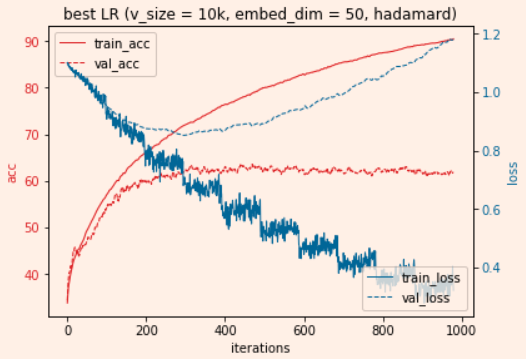

The following function may be useful to you to accomplish this, but you are also welcome to modify it or write your own plotting code.

In [34]:
def plot_over_training(per_epoch_metrics, title_name):
  """Utility function to plot train/val accuracies and losses.

  @param per_epoch_metrics: a dictionary of lists, where each list represents a metric over the
      course of training.
  @param title_name: String to show on the plot title.
  """
  t = np.arange(0, len(per_epoch_metrics['train_accs']))
  train_acc = per_epoch_metrics['train_accs']
  val_acc = per_epoch_metrics['val_accs']
  train_loss = per_epoch_metrics['train_losses']
  val_loss = per_epoch_metrics['val_losses']

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('acc', color=color)
  ax1.plot(t, train_acc, color=color, linewidth=1, label = 'train_acc')
  ax1.plot(t, val_acc, color=color, linestyle='dashed', linewidth=1, label = 'val_acc')
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.legend(loc='upper left')
  ax2 = ax1.twinx() 

  color = 'tab:blue'
  ax2.set_ylabel('loss', color=color)  # we already handled the x-label with ax1
  ax2.plot(t, train_loss, color=color, linewidth=1, label = 'train_loss')
  ax2.plot(t, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.legend(loc='lower right')
  fig.tight_layout() 
  plt.title(title_name)
  plt.show()

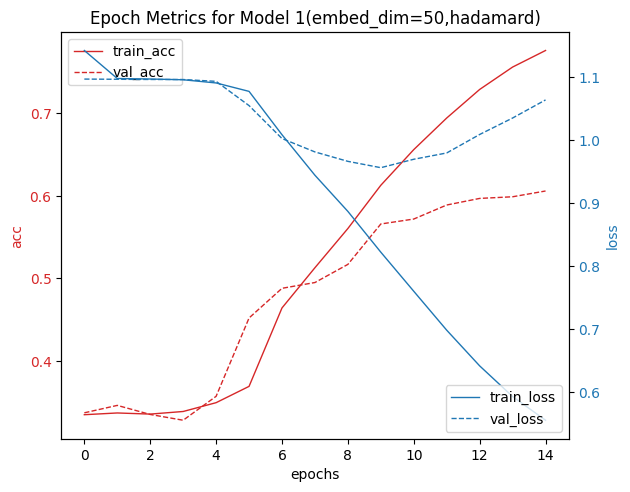

In [35]:
plot_over_training(per_epoch_metrics1,'Epoch Metrics for Model 1(embed_dim=50,hadamard)')

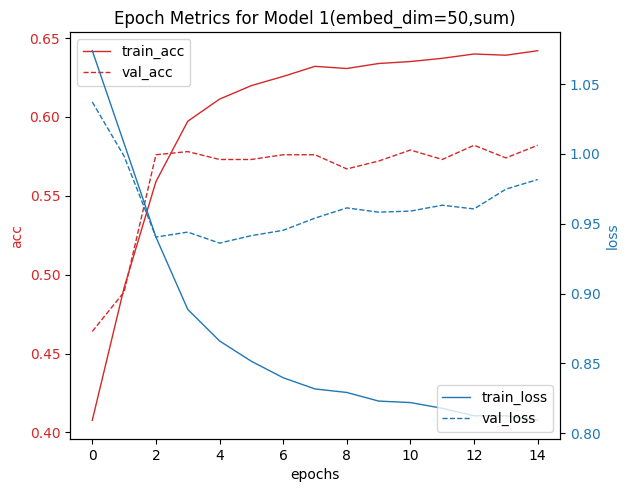

In [201]:
plot_over_training(per_epoch_metrics2,'Epoch Metrics for Model 1(embed_dim=50,sum)')

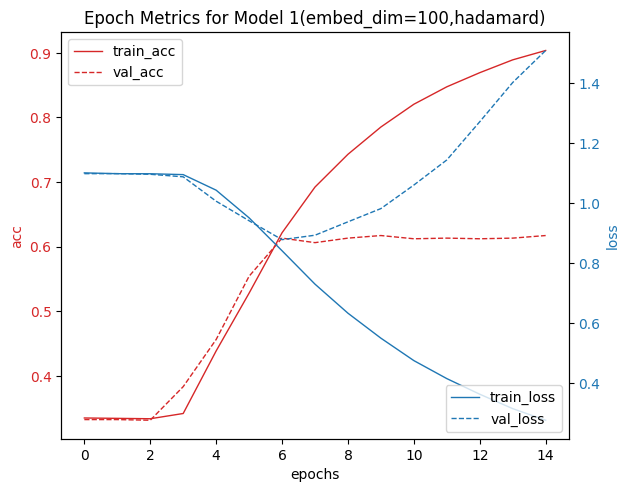

In [202]:
plot_over_training(per_epoch_metrics3,'Epoch Metrics for Model 1(embed_dim=100,hadamard)')

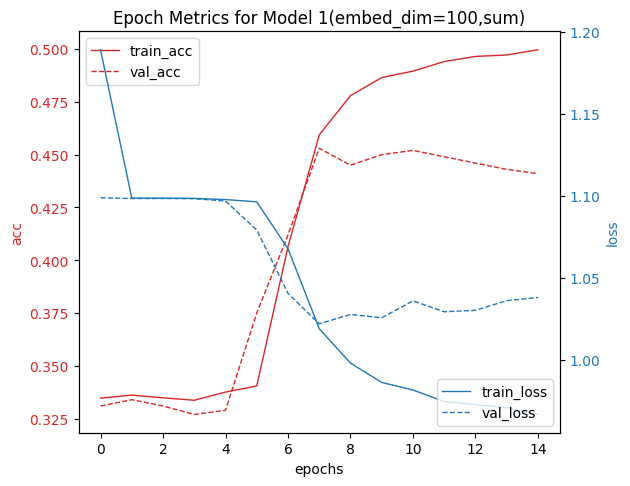

In [203]:
plot_over_training(per_epoch_metrics4,'Epoch Metrics for Model 1(embed_dim=100,sum)')

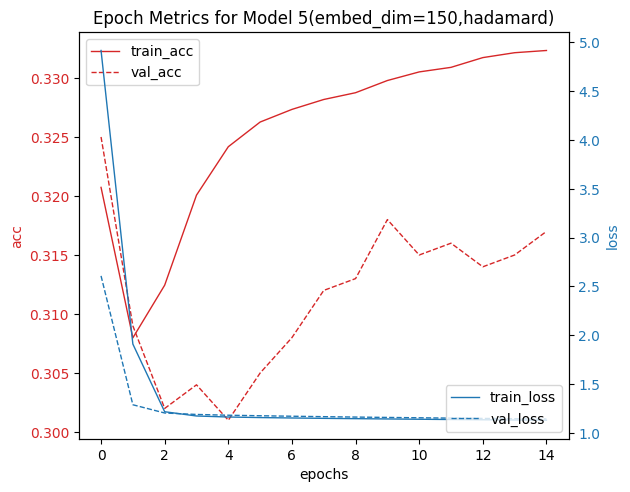

In [204]:
plot_over_training(per_epoch_metrics5,'Epoch Metrics for Model 5(embed_dim=150,hadamard)')

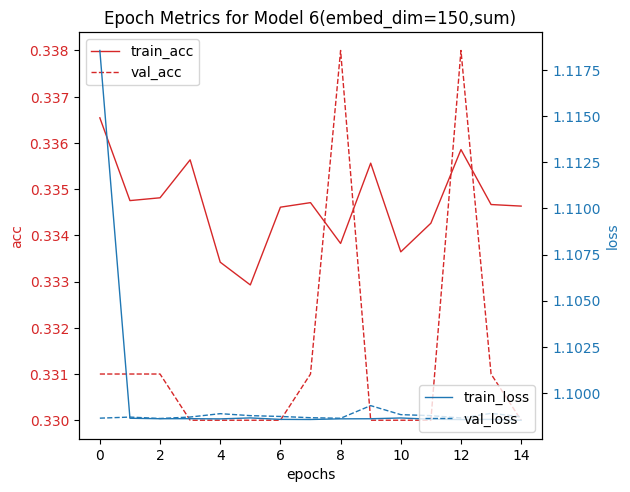

In [205]:
plot_over_training(per_epoch_metrics6,'Epoch Metrics for Model 6(embed_dim=150,sum)')

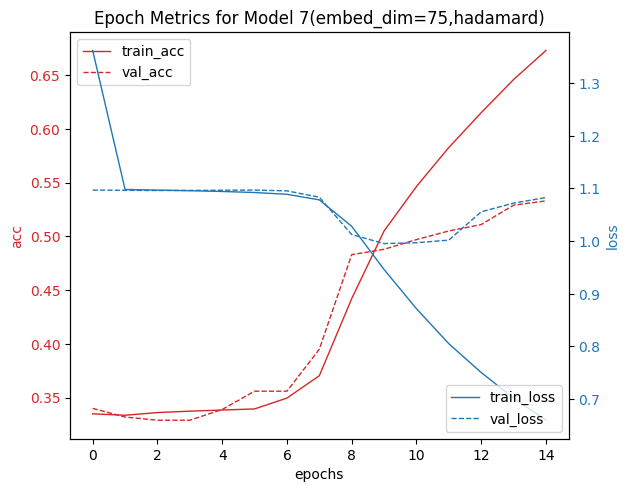

In [206]:
plot_over_training(per_epoch_metrics7,'Epoch Metrics for Model 7(embed_dim=75,hadamard)')

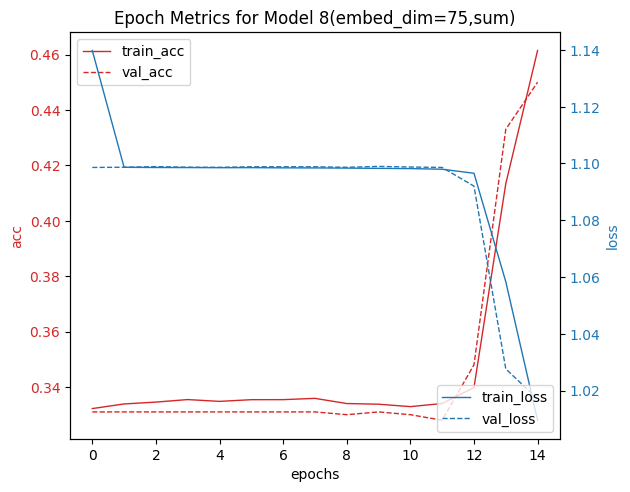

In [207]:
plot_over_training(per_epoch_metrics8,'Epoch Metrics for Model 8(embed_dim=75,sum)')

**Written 2:** (4 pts)   
Take your best model based on validation performace and report its validation accuracy:

In [36]:
print ("Validation Loss for the best model is "+str(max(per_epoch_metrics1['val_losses'])))
print ("Validation Accuracy for the best model is "+str(max(per_epoch_metrics1['val_accs'])))

Validation Loss for the best model is 1.0972845554351807
Validation Accuracy for the best model is 0.606


In [7]:
#hypo_data_tokens_val
#prem_data_tokens_val
#label_index_val

pandas.core.series.Series

**Written 3:** (4 pts)

Highlight 3 correct and 3 incorrect predictions in this validation set. Describe why the model might have gotten the 3 incorrect predictions wrong.

In [40]:
label_dict = {0:"neutral",1:"entail",2:"contradict"}

def check_evaluation(golds,predictions):
    correct = 0
    wrong = 0
    correct_list = []
    incorrect_list = []
    correct_prediction_label = []
    actual_label = []
    predicted_incorrect_label = []
    if len(golds) != len(predictions):
        raise Exception("Mismatched gold/pred lengths: %i / %i" % (len(golds), len(predictions)))
    for idx in range(0, len(golds)):
        gold = golds[idx]
        prediction = predictions[idx]
        if correct!=3 and prediction == gold:
            correct += 1
            correct_list.append(idx)
            correct_prediction_label.append(prediction)
        if wrong!=3 and prediction !=gold:
            wrong += 1
            incorrect_list.append(idx)
            predicted_incorrect_label.append(prediction)
            actual_label.append(gold)
        if (correct==3 and wrong==3):
            return correct_list,incorrect_list,correct_prediction_label,predicted_incorrect_label,actual_label

def test(validation_set,model):
    # Validation Loop
    model.eval()
    with torch.no_grad():
        for _,batch in enumerate(tqdm(validation_set)):
            hypo_token,hypo_len,prem_token,prem_len,target_label = batch
            
            y_hat = model(hypo_token,hypo_len,prem_token,prem_len)

            pred = torch.argmax(y_hat,dim=1)
    
            correct_list,incorrect_list,correct_prediction_label,predicted_incorrect_label,actual_label = check_evaluation(target_label.tolist(),pred.tolist())
    return correct_list,incorrect_list,correct_prediction_label,predicted_incorrect_label,actual_label

correct_list,incorrect_list,correct_prediction_label,predicted_incorrect_label,actual_label = test(validation_generator,initial_model)


print ("Correct Predictions")
for k in correct_list:
    print ("Premise ")
    prem_token = [] 
    for j in prem_data_indices_val[k]:
        if (id2token[j]!="<PAD>"):
            prem_token.append(id2token[j])
    print (" ".join(prem_token))
    print ("Hypothesis")
    hypo_token = [] 
    for j in hypo_data_indices_val[k]:
        if (id2token[j]!="<PAD>"):
            hypo_token.append(id2token[j])
    print (" ".join(hypo_token))
    label = correct_prediction_label[correct_list.index(k)]
    print ("Label Predicted Correctly "+str(label)+": "+label_dict.get(label))
    print ("----------------------------")

100%|██████████| 1/1 [00:00<00:00, 24.99it/s]

Correct Predictions
Premise 
three women on a stage one wearing red shoes black pants and a gray shirt is sitting on a prop another is sitting on the floor and the third wearing a black shirt and pants is standing as a gentleman in the back tunes an instrument
Hypothesis
there are two women standing on the stage
Label Predicted Correctly 2: contradict
----------------------------
Premise 
four people sit on a subway two read books one looks at a cellphone and is wearing knee high boots
Hypothesis
multiple people are on a subway together with each of them doing their own thing
Label Predicted Correctly 2: contradict
----------------------------
Premise 
bicycles stationed while a group of people socialize
Hypothesis
people get together near a stand of bicycles
Label Predicted Correctly 0: neutral
----------------------------


In [42]:
print ("Incorrect Predictions")
for k in incorrect_list:
    print ("Premise ")
    prem_token = [] 
    for j in prem_data_indices_val[k]:
        if (id2token[j]!="<PAD>"):
            prem_token.append(id2token[j])
    print (" ".join(prem_token))
    print ("Hypothesis")
    hypo_token = [] 
    for j in hypo_data_indices_val[k]:
        if (id2token[j]!="<PAD>"):
            hypo_token.append(id2token[j])
    print (" ".join(hypo_token))
    correct_label = actual_label[incorrect_list.index(k)]
    incorrect_label = predicted_incorrect_label[incorrect_list.index(k)]
    print ("Label Predicted Incorrectly ")
    print ("Model predicted "+str(incorrect_label)+": "+label_dict.get(incorrect_label))
    print ("Actual Label is "+str(correct_label)+": "+label_dict.get(correct_label))
    print ("----------------------------")


Incorrect Predictions
Premise 
two women one walking her dog the other pushing a stroller
Hypothesis
there is a snowstorm
Label Predicted Incorrectly 
Model predicted 0: neutral
Actual Label is 1: entail
----------------------------
Premise 
three people and a white dog are sitting in the sand on a beach
Hypothesis
three dogs and a person are sitting in the snow
Label Predicted Incorrectly 
Model predicted 2: contradict
Actual Label is 0: neutral
----------------------------
Premise 
a large group of people stand outside on a road while people on a higher level look on at them
Hypothesis
one group of people are watching what another group does
Label Predicted Incorrectly 
Model predicted 2: contradict
Actual Label is 1: entail
----------------------------


The predictions which are wrong usually involve simple numeric values which are mismatched according to the prediciton label and the actual label. 

Other factors could be not remembering the context of earlier words which can lead to vanishing gradient problems. The RNN model we have implemented might be a bit too simplistic for such a nuanced and grammatical task.